In this work I have used Google style docstrings/comments . In this submission , the code can take 11+ hours to run fully , therefore certain functions have not been called and the lines have been commented out.

In [ ]:
# Cell 1: Imports and RNG helper 

import math
from dataclasses import dataclass
from typing import List, Tuple , Optional , Dict

import numpy as np
import matplotlib.pyplot as plt


def make_rng(seed: int) -> np.random.Generator:
    """Create a NumPy random number generator.

    Args:
        seed (int): Integer random seed.

    Returns:
        np.random.Generator: NumPy random number generator instance.
    """
    return np.random.default_rng(seed)


In [ ]:
#   Cell 2: error estimation and fitting helpers 

from typing import Optional


def blocking_error(x: np.ndarray) -> Tuple[float, float]:
    """Estimate mean and standard error using a simple blocking method.

    The method repeatedly merges neighbouring pairs of samples and
    tracks how the variance of block means stabilises.

    Args:
        x (np.ndarray): One dimensional array of samples.

    Returns:
        Tuple[float, float]: Mean and standard error of the mean.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    mean_x = float(np.mean(x))
    if n < 16:
        if n <= 1:
            return mean_x, 0.0
        var = np.var(x, ddof=1)
        se = math.sqrt(var / n)
        return mean_x, se

    # Work on a copy
    y = x.copy()
    num_blocks = y.size
    var_block = np.var(y, ddof=1)
    while num_blocks >= 4:
        if num_blocks % 2 == 1:
            y = y[:-1]
            num_blocks = y.size
        y = 0.5 * (y[0::2] + y[1::2])
        num_blocks = y.size
        var_block = np.var(y, ddof=1)

    se = math.sqrt(var_block / max(num_blocks - 1, 1))
    return mean_x, se


def linear_fit_with_errors(
    x: np.ndarray, y: np.ndarray, sigma_y: Optional[np.ndarray] = None
) -> Tuple[float, float, float, float, float, int]:
    """Perform a weighted linear fit y = a + b x.

    Args:
        x (np.ndarray): One dimensional array of x values.
        y (np.ndarray): One dimensional array of y values.
        sigma_y (np.ndarray, optional): Standard deviations of y. If None,
            an unweighted fit is performed.

    Returns:
        Tuple[float, float, float, float, float, int]:
            intercept a, slope b, sigma_a, sigma_b, chi2, dof.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = x.size
    if sigma_y is None:
        sigma_y = np.ones_like(y)
    else:
        sigma_y = np.asarray(sigma_y, dtype=float)

    w = 1.0 / (sigma_y ** 2)
    sw = np.sum(w)
    swx = np.sum(w * x)
    swy = np.sum(w * y)
    swxx = np.sum(w * x * x)
    swxy = np.sum(w * x * y)

    denom = sw * swxx - swx * swx
    if denom <= 0.0:
        # Fall back to numpy if something goes wrong
        b, a = np.polyfit(x, y, 1)
        return a, b, float("nan"), float("nan"), float("nan"), n - 2

    a = (swxx * swy - swx * swxy) / denom
    b = (sw * swxy - swx * swy) / denom

    sigma_a = math.sqrt(swxx / denom)
    sigma_b = math.sqrt(sw / denom)

    y_fit = a + b * x
    chi2 = float(np.sum(((y - y_fit) / sigma_y) ** 2))
    dof = max(n - 2, 1)
    return a, b, sigma_a, sigma_b, chi2, dof


In [ ]:
#  Cell 3: 1D Ising utilities 

def ising1d_initial_state(num_spins: int, rng: np.random.Generator) -> np.ndarray:
    """Initialise a 1D Ising chain with random spins.

    Args:
        num_spins (int): Number of spins in the chain.
        rng (np.random.Generator): Random number generator.

    Returns:
        np.ndarray: Array of spins with values +1 or -1.
    """
    spins = rng.choice([-1, 1], size=num_spins)
    return spins.astype(np.int8)


def ising1d_energy(spins: np.ndarray, coupling: float = 1.0) -> float:
    """Compute the total energy of a 1D Ising chain with periodic boundaries.

    Args:
        spins (np.ndarray): One dimensional array of spins.
        coupling (float): Coupling constant J.

    Returns:
        float: Total energy of the configuration.
    """
    interaction = spins * np.roll(spins, -1)
    energy = -coupling * np.sum(interaction)
    return float(energy)


def metropolis_sweep_1d(
    spins: np.ndarray,
    beta: float,
    rng: np.random.Generator,
    coupling: float = 1.0,
) -> None:
    """Perform a single Metropolis sweep over a 1D chain.

    Spins are updated in random order.

    Args:
        spins (np.ndarray): One dimensional array of spins to be updated in place.
        beta (float): Inverse temperature 1 / T.
        rng (np.random.Generator): Random number generator.
        coupling (float): Coupling constant J.

    Returns:
        None: The spins array is updated in place.
    """
    num_spins = spins.size
    for _ in range(num_spins):
        i = rng.integers(0, num_spins)
        left = spins[(i - 1) % num_spins]
        right = spins[(i + 1) % num_spins]
        delta_e = 2.0 * coupling * spins[i] * (left + right)
        if delta_e <= 0.0:
            spins[i] *= -1
        else:
            if rng.random() < math.exp(-beta * delta_e):
                spins[i] *= -1


def ising1d_exact_energy_per_spin(beta: float, coupling: float = 1.0) -> float:
    """Compute analytic energy per spin for the infinite 1D Ising chain.

    Uses the thermodynamic limit result:

        e_exact / J = -tanh(beta * J)

    Args:
        beta (float): Inverse temperature 1 / T.
        coupling (float): Coupling constant J.

    Returns:
        float: Analytic energy per spin in units of J.
    """
    return -coupling * math.tanh(beta * coupling)


In [ ]:
#  Cell 4: 2D Ising utilities 

def ising2d_initial_state(lattice_size: int, rng: np.random.Generator) -> np.ndarray:
    """Initialise a 2D Ising lattice with random spins.

    Args:
        lattice_size (int): Linear size L of the lattice.
        rng (np.random.Generator): Random number generator.

    Returns:
        np.ndarray: Two dimensional array of spins with values +1 or -1.
    """
    spins = rng.choice([-1, 1], size=(lattice_size, lattice_size))
    return spins.astype(np.int8)


def ising2d_energy(spins: np.ndarray, coupling: float = 1.0) -> float:
    """Compute the total energy of a 2D Ising model with periodic boundaries.

    Args:
        spins (np.ndarray): Two dimensional array of spins.
        coupling (float): Coupling constant J.

    Returns:
        float: Total energy of the configuration.
    """
    right = np.roll(spins, shift=-1, axis=1)
    down = np.roll(spins, shift=-1, axis=0)
    interaction = spins * (right + down)
    energy = -coupling * np.sum(interaction)
    return float(energy)


def metropolis_sweep_2d(
    spins: np.ndarray,
    beta: float,
    rng: np.random.Generator,
    coupling: float = 1.0,
) -> None:
    """Perform a Metropolis sweep over all spins in a 2D lattice.

    Spins are updated in random order.

    Args:
        spins (np.ndarray): Two dimensional array of spins to be updated in place.
        beta (float): Inverse temperature 1 / T.
        rng (np.random.Generator): Random number generator.
        coupling (float): Coupling constant J.

    Returns:
        None: The spins array is updated in place.
    """
    l = spins.shape[0]
    num_sites = l * l
    for _ in range(num_sites):
        i = rng.integers(0, l)
        j = rng.integers(0, l)
        up = spins[(i - 1) % l, j]
        down = spins[(i + 1) % l, j]
        left = spins[i, (j - 1) % l]
        right = spins[i, (j + 1) % l]
        neighbour_sum = up + down + left + right
        delta_e = 2.0 * coupling * spins[i, j] * neighbour_sum
        if delta_e <= 0.0:
            spins[i, j] *= -1
        else:
            if rng.random() < math.exp(-beta * delta_e):
                spins[i, j] *= -1


def measure_observables_2d(spins: np.ndarray, beta: float) -> Tuple[float, float]:
    """Measure energy per spin and magnetisation per spin for a 2D configuration.

    Args:
        spins (np.ndarray): Two dimensional array of spins.
        beta (float): Inverse temperature (not directly used here).

    Returns:
        Tuple[float, float]: Energy per spin and magnetisation per spin.
    """
    energy = ising2d_energy(spins)
    num_sites = spins.size
    energy_per_spin = energy / num_sites
    magnetisation_per_spin = float(np.sum(spins)) / num_sites
    return energy_per_spin, magnetisation_per_spin


T = 0.010  <|M|> = 0.5000  C_v = 0.0000  chi = 0.0000
T = 0.453  <|M|> = 0.1583  C_v = 0.0189  chi = 17.6769
T = 0.897  <|M|> = 0.9998  C_v = 0.0085  chi = 0.0005
T = 1.340  <|M|> = 0.9932  C_v = 0.1201  chi = 0.0142
T = 1.783  <|M|> = 0.9598  C_v = 0.4547  chi = 0.0966
T = 2.227  <|M|> = 0.7612  C_v = 1.2211  chi = 3.0962
T = 2.670  <|M|> = 0.2725  C_v = 0.5869  chi = 3.0593
T = 3.113  <|M|> = 0.1529  C_v = 0.3606  chi = 0.9903
T = 3.557  <|M|> = 0.1240  C_v = 0.2202  chi = 0.5916
T = 4.000  <|M|> = 0.1068  C_v = 0.1795  chi = 0.3726


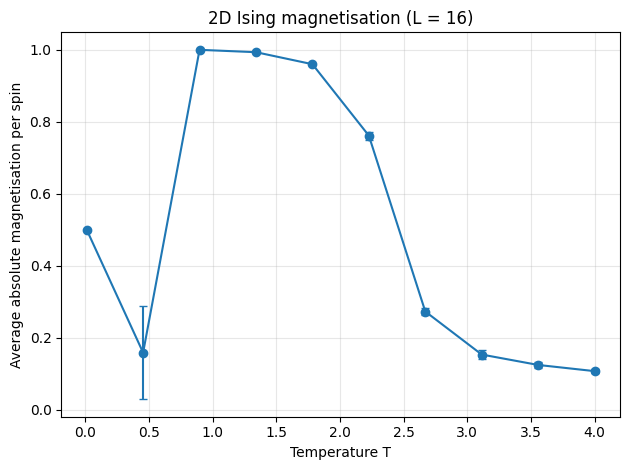

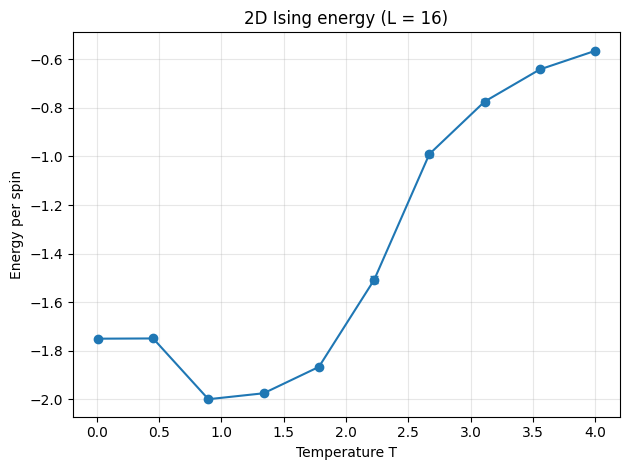

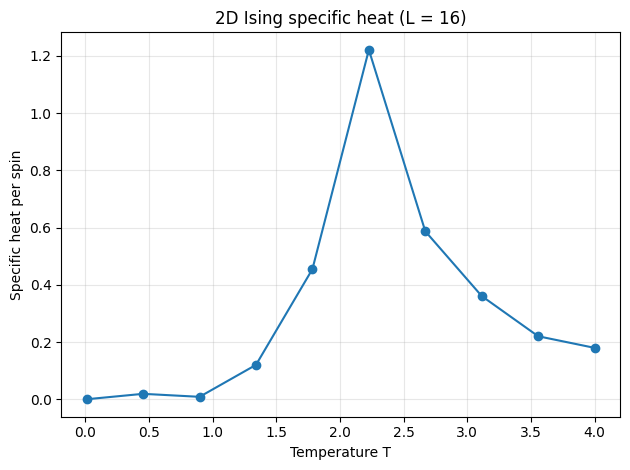

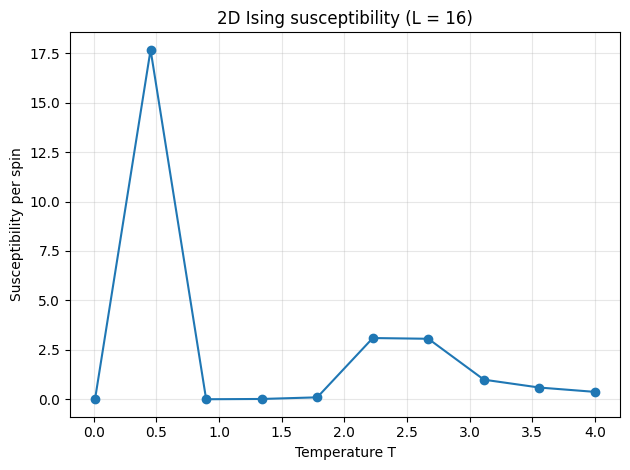

In [ ]:
#  Cell 5: 2D temperature sweep (L = 16, T = 0.01..4.0) with error bars 

def run_ising2d_temperature_sweep() -> None:
    """Run a 2D Ising temperature sweep for a single lattice size.

    Adds error bars using blocking errors on energy and magnetisation.

    Args:
        None

    Returns:
        None
    """
    rng = make_rng(seed=321)

    lattice_size = 16
    t_min = 0.01
    t_max = 4.0
    num_temps = 10

    num_burn_in_sweeps = 1000
    num_measure_sweeps = 5000
    sample_interval = 10

    temperatures = np.linspace(t_min, t_max, num_temps)
    beta_values = 1.0 / temperatures

    energies_mean = []
    energies_se = []
    mags_abs_mean = []
    mags_abs_se = []
    cvs = []
    chis = []

    spins = ising2d_initial_state(lattice_size=lattice_size, rng=rng)
    num_sites = spins.size

    for beta, temp in zip(beta_values, temperatures):
        for _ in range(num_burn_in_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng)

        e_samples = []
        m_samples = []

        for sweep in range(num_measure_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng)
            if sweep % sample_interval == 0:
                e, m = measure_observables_2d(spins, beta)
                e_samples.append(e)
                m_samples.append(m)

        e_arr = np.array(e_samples, dtype=float)
        m_arr = np.array(m_samples, dtype=float)
        m_abs_arr = np.abs(m_arr)

        e_mean, e_se = blocking_error(e_arr)
        m_abs_mean, m_abs_se = blocking_error(m_abs_arr)

        energy_var = float(np.var(e_arr, ddof=1))
        cv = (beta ** 2) * num_sites * energy_var

        chi = beta * num_sites * (
            float(np.mean(m_arr ** 2)) - float(np.mean(m_abs_arr) ** 2)
        )

        energies_mean.append(e_mean)
        energies_se.append(e_se)
        mags_abs_mean.append(m_abs_mean)
        mags_abs_se.append(m_abs_se)
        cvs.append(cv)
        chis.append(chi)

        print(
            f"T = {temp:.3f}  <|M|> = {m_abs_mean:.4f}  "
            f"C_v = {cv:.4f}  chi = {chi:.4f}"
        )

    energies_mean = np.array(energies_mean)
    energies_se = np.array(energies_se)
    mags_abs_mean = np.array(mags_abs_mean)
    mags_abs_se = np.array(mags_abs_se)
    cvs = np.array(cvs)
    chis = np.array(chis)

    plt.figure()
    plt.errorbar(
        temperatures,
        mags_abs_mean,
        yerr=mags_abs_se,
        fmt="o-",
        capsize=3,
    )
    plt.xlabel("Temperature T")
    plt.ylabel("Average absolute magnetisation per spin")
    plt.title("2D Ising magnetisation (L = 16)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.errorbar(
        temperatures,
        energies_mean,
        yerr=energies_se,
        fmt="o-",
        capsize=3,
    )
    plt.xlabel("Temperature T")
    plt.ylabel("Energy per spin")
    plt.title("2D Ising energy (L = 16)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(temperatures, cvs, "o-")
    plt.xlabel("Temperature T")
    plt.ylabel("Specific heat per spin")
    plt.title("2D Ising specific heat (L = 16)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(temperatures, chis, "o-")
    plt.xlabel("Temperature T")
    plt.ylabel("Susceptibility per spin")
    plt.title("2D Ising susceptibility (L = 16)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


run_ising2d_temperature_sweep()


In [ ]:
#  Cell 6: finite size scaling helpers 

@dataclass
class SimulationResult:
    """Container for simulation results for a given lattice size and temperature.

    Attributes:
        temperature (float): Simulation temperature T.
        energy_mean (float): Mean energy per spin.
        energy_var (float): Variance of the energy per spin.
        mag_mean (float): Mean magnetisation per spin.
        mag_abs_mean (float): Mean absolute magnetisation per spin.
        mag2_mean (float): Mean of the squared magnetisation per spin.
    """

    temperature: float
    energy_mean: float
    energy_var: float
    mag_mean: float
    mag_abs_mean: float
    mag2_mean: float


def run_ising2d_simulation(
    lattice_size: int,
    temperature: float,
    num_sweeps: int,
    burn_in_sweeps: int,
    sample_interval: int,
    rng: np.random.Generator,
) -> SimulationResult:
    """Run a 2D Ising simulation and measure observables.

    Args:
        lattice_size (int): Linear lattice size L.
        temperature (float): Temperature T.
        num_sweeps (int): Number of total sweeps after burn-in.
        burn_in_sweeps (int): Number of sweeps for burn-in.
        sample_interval (int): Interval between measurements in sweeps.
        rng (np.random.Generator): Random number generator.

    Returns:
        SimulationResult: Object containing energy and magnetisation statistics.
    """
    beta = 1.0 / temperature
    spins = ising2d_initial_state(lattice_size=lattice_size, rng=rng)
    num_sites = lattice_size * lattice_size

    for _ in range(burn_in_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)

    energy_samples = []
    mag_samples = []

    for sweep in range(num_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)
        if sweep % sample_interval == 0:
            e, m = measure_observables_2d(spins, beta)
            energy_samples.append(e)
            mag_samples.append(m)

    e_arr = np.array(energy_samples)
    m_arr = np.array(mag_samples)
    m_abs_arr = np.abs(m_arr)

    energy_mean = float(np.mean(e_arr))
    energy_var = float(np.var(e_arr, ddof=1))
    mag_mean = float(np.mean(m_arr))
    mag_abs_mean = float(np.mean(m_abs_arr))
    mag2_mean = float(np.mean(m_arr ** 2))

    return SimulationResult(
        temperature=temperature,
        energy_mean=energy_mean,
        energy_var=energy_var,
        mag_mean=mag_mean,
        mag_abs_mean=mag_abs_mean,
        mag2_mean=mag2_mean,
    )


Starting finite size study for L = 16
L = 16, T = 1.800  <|M|> = 0.9572  C_v = 0.4346 +- 0.0252  chi = 0.1072 +- 0.7610
L = 16, T = 1.852  <|M|> = 0.9493  C_v = 0.4832 +- 0.0519  chi = 0.1716 +- 0.5432
L = 16, T = 1.904  <|M|> = 0.9390  C_v = 0.5433 +- 0.0570  chi = 0.1720 +- 0.1999
L = 16, T = 1.957  <|M|> = 0.9229  C_v = 0.6629 +- 0.0519  chi = 0.3979 +- 1.8189
L = 16, T = 2.009  <|M|> = 0.9098  C_v = 0.6967 +- 0.0295  chi = 0.4279 +- 0.8284
L = 16, T = 2.061  <|M|> = 0.8806  C_v = 0.9463 +- 0.0857  chi = 0.9920 +- 1.6150
L = 16, T = 2.113  <|M|> = 0.8578  C_v = 1.0953 +- 0.2981  chi = 1.2759 +- 1.9901
L = 16, T = 2.165  <|M|> = 0.8334  C_v = 1.0592 +- 0.2076  chi = 1.3283 +- 2.5068
L = 16, T = 2.217  <|M|> = 0.7879  C_v = 1.3003 +- 0.0871  chi = 2.2560 +- 1.1600
L = 16, T = 2.270  <|M|> = 0.7148  C_v = 1.5895 +- 0.0524  chi = 4.1212 +- 1.2050
L = 16, T = 2.322  <|M|> = 0.6410  C_v = 1.4354 +- 0.0076  chi = 5.0047 +- 0.1500
L = 16, T = 2.374  <|M|> = 0.5798  C_v = 1.4214 +- 0.0036  c

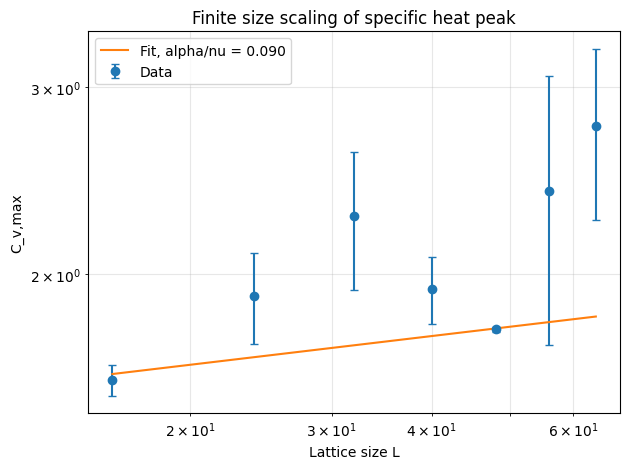

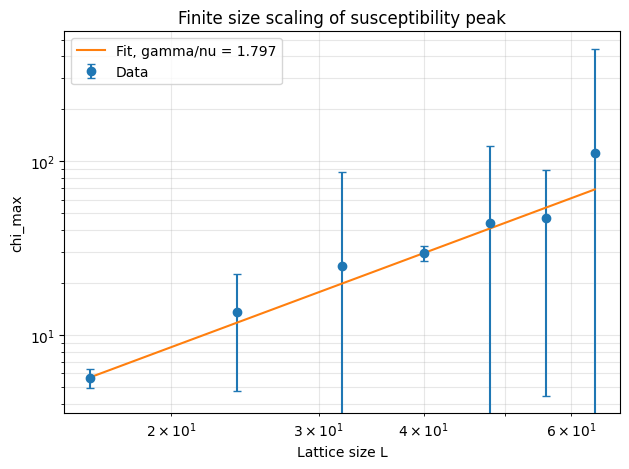

Alternative fit C_v,max(L) ~ a + b log L:
  b = 0.155 +- 0.048, chi2/dof = 2.09


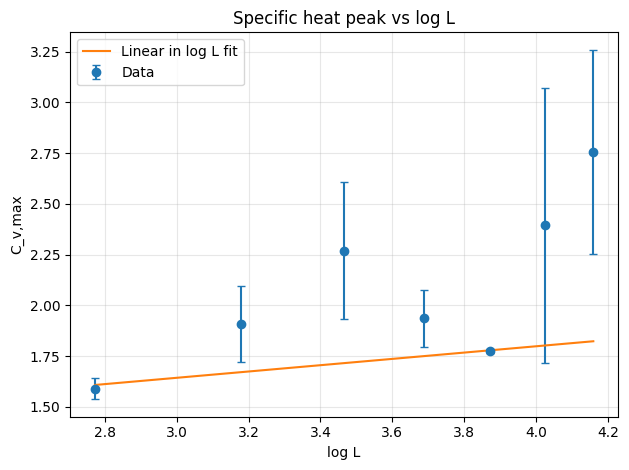

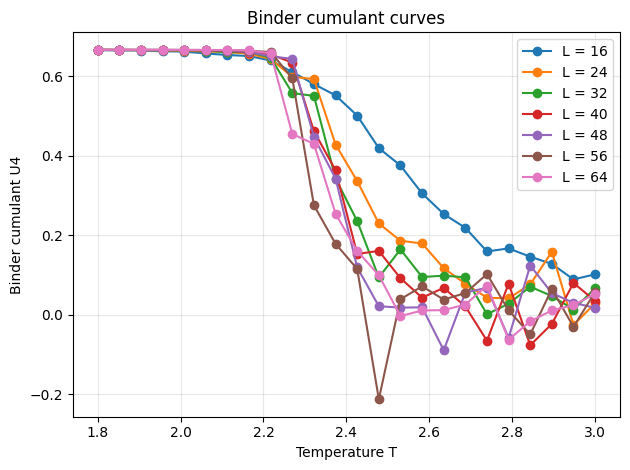

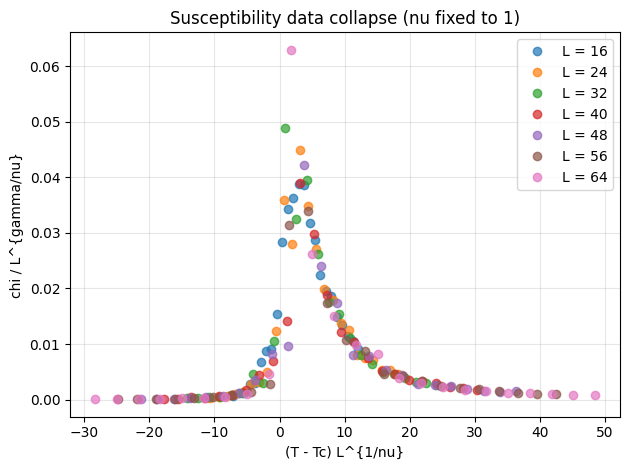

In [ ]:
#  Cell 7: finite size scaling with uncertainties, Binder, and collapse 

def simulate_ising2d_samples(
    lattice_size: int,
    temperature: float,
    num_sweeps: int,
    burn_in_sweeps: int,
    sample_interval: int,
    rng: np.random.Generator,
) -> Tuple[np.ndarray, np.ndarray]:
    """Run a 2D Ising simulation and return energy and magnetisation samples.

    Args:
        lattice_size (int): Linear lattice size L.
        temperature (float): Temperature T.
        num_sweeps (int): Number of sweeps after burn-in.
        burn_in_sweeps (int): Number of burn-in sweeps.
        sample_interval (int): Interval between measurements.
        rng (np.random.Generator): Random number generator.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Arrays of energy per spin and
            magnetisation per spin samples.
    """
    beta = 1.0 / temperature
    spins = ising2d_initial_state(lattice_size=lattice_size, rng=rng)
    num_sites = lattice_size * lattice_size

    for _ in range(burn_in_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)

    e_samples = []
    m_samples = []
    for sweep in range(num_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)
        if sweep % sample_interval == 0:
            e, m = measure_observables_2d(spins, beta)
            e_samples.append(e)
            m_samples.append(m)

    e_arr = np.array(e_samples, dtype=float)
    m_arr = np.array(m_samples, dtype=float)
    return e_arr, m_arr


def run_finite_size_scaling() -> None:
    """Perform a finite size scaling study for the 2D Ising model.

    Adds:
        - Statistical errors on C_v and chi using blocking.
        - Error bars on C_v,max(L) and chi_max(L).
        - Weighted fits for gamma_over_nu and alpha_over_nu.
        - C_v,max(L) vs log(L) fit (to check logarithmic growth).
        - Estimate of T_c(infinity) from chi peak positions.
        - Binder cumulant curves U4(L, T).
        - Susceptibility data collapse plot.

    Args:
        None

    Returns:
        None
    """
    rng = make_rng(seed=987)

    lattice_sizes = [16, 24, 32, 40, 48, 56, 64]
    t_min = 1.8
    t_max = 3.0
    num_temps = 24

    num_sweeps = 12000
    burn_in_sweeps = 4000
    sample_interval = 10

    temperatures = np.linspace(t_min, t_max, num_temps)

    # Per L storage
    cv_max_list = []
    cv_max_err_list = []
    chi_max_list = []
    chi_max_err_list = []
    cv_max_t_list = []
    chi_max_t_list = []

    tc_estimates = []
    tc_estimates_err = []

    # Store full chi(L, T) for data collapse
    chi_all = {}
    chi_err_all = {}
    binder_all = {}

    for l in lattice_sizes:
        num_sites = l * l
        cvs_l = []
        cvs_err_l = []
        chis_l = []
        chis_err_l = []
        binder_l = []

        print(f"Starting finite size study for L = {l}")
        for temp in temperatures:
            beta = 1.0 / temp
            e_arr, m_arr = simulate_ising2d_samples(
                lattice_size=l,
                temperature=temp,
                num_sweeps=num_sweeps,
                burn_in_sweeps=burn_in_sweeps,
                sample_interval=sample_interval,
                rng=rng,
            )

            # Basic statistics
            e_mean = float(np.mean(e_arr))
            m_abs_arr = np.abs(m_arr)
            m2_arr = m_arr ** 2
            m4_arr = m_arr ** 4

            # Specific heat via per-sample estimator
            e_fluct = e_arr - e_mean
            cv_samples = (beta ** 2) * num_sites * (e_fluct ** 2)
            cv_mean, cv_se = blocking_error(cv_samples)

            # Susceptibility via per-sample estimator
            m_abs_mean = float(np.mean(m_abs_arr))
            chi_samples = beta * num_sites * (m2_arr - m_abs_mean ** 2)
            chi_mean, chi_se = blocking_error(chi_samples)

            # Binder cumulant: U4 = 1 - <m^4> / (3 <m^2>^2)
            m2_mean = float(np.mean(m2_arr))
            m4_mean = float(np.mean(m4_arr))
            if m2_mean > 0.0:
                u4 = 1.0 - m4_mean / (3.0 * m2_mean * m2_mean)
            else:
                u4 = 0.0

            cvs_l.append(cv_mean)
            cvs_err_l.append(cv_se)
            chis_l.append(chi_mean)
            chis_err_l.append(chi_se)
            binder_l.append(u4)

            print(
                f"L = {l:2d}, T = {temp:.3f}  "
                f"<|M|> = {m_abs_mean:.4f}  "
                f"C_v = {cv_mean:.4f} +- {cv_se:.4f}  "
                f"chi = {chi_mean:.4f} +- {chi_se:.4f}"
            )

        cvs_l = np.array(cvs_l)
        cvs_err_l = np.array(cvs_err_l)
        chis_l = np.array(chis_l)
        chis_err_l = np.array(chis_err_l)
        binder_l = np.array(binder_l)

        chi_all[l] = chis_l
        chi_err_all[l] = chis_err_l
        binder_all[l] = binder_l

        # Peak locations by discrete maximum
        idx_cv = int(np.argmax(cvs_l))
        idx_chi = int(np.argmax(chis_l))

        cv_max = float(cvs_l[idx_cv])
        cv_max_err = float(cvs_err_l[idx_cv])
        t_cv_max = float(temperatures[idx_cv])

        chi_max = float(chis_l[idx_chi])
        chi_max_err = float(chis_err_l[idx_chi])
        t_chi_max = float(temperatures[idx_chi])

        cv_max_list.append(cv_max)
        cv_max_err_list.append(cv_max_err)
        chi_max_list.append(chi_max)
        chi_max_err_list.append(chi_max_err)
        cv_max_t_list.append(t_cv_max)
        chi_max_t_list.append(t_chi_max)

        print(
            f"Completed sweep for L = {l}, "
            f"max C_v = {cv_max:.3f} +- {cv_max_err:.3f} at T = {t_cv_max:.3f}, "
            f"max chi = {chi_max:.3f} +- {chi_max_err:.3f} at T = {t_chi_max:.3f}"
        )

        # Record finite size estimate of Tc from chi peak
        tc_estimates.append(t_chi_max)
        # Simple crude error: half the temperature spacing
        dt = (t_max - t_min) / (num_temps - 1)
        tc_estimates_err.append(0.5 * dt)

    lattice_sizes_arr = np.array(lattice_sizes, dtype=float)
    cv_max_arr = np.array(cv_max_list)
    cv_max_err_arr = np.array(cv_max_err_list)
    chi_max_arr = np.array(chi_max_list)
    chi_max_err_arr = np.array(chi_max_err_list)
    tc_estimates_arr = np.array(tc_estimates)
    tc_estimates_err_arr = np.array(tc_estimates_err)

    #  Exponent fits: log-log with errors 
    log_L = np.log(lattice_sizes_arr)

    log_cv = np.log(cv_max_arr)
    sigma_log_cv = cv_max_err_arr / cv_max_arr
    a_cv, b_cv, sigma_a_cv, sigma_b_cv, chi2_cv, dof_cv = linear_fit_with_errors(
        log_L, log_cv, sigma_log_cv
    )
    alpha_over_nu = b_cv
    alpha_over_nu_err = sigma_b_cv

    log_chi = np.log(chi_max_arr)
    sigma_log_chi = chi_max_err_arr / chi_max_arr
    a_chi, b_chi, sigma_a_chi, sigma_b_chi, chi2_chi, dof_chi = linear_fit_with_errors(
        log_L, log_chi, sigma_log_chi
    )
    gamma_over_nu = b_chi
    gamma_over_nu_err = sigma_b_chi

    print("Finite-size scaling exponent estimates (log-log fits):")
    print(
        f"  alpha / nu from C_v peaks  = {alpha_over_nu:.3f} +- {alpha_over_nu_err:.3f}, "
        f"chi2/dof = {chi2_cv / max(dof_cv, 1):.2f}"
    )
    print(
        f"  gamma / nu from chi peaks = {gamma_over_nu:.3f} +- {gamma_over_nu_err:.3f}, "
        f"chi2/dof = {chi2_chi / max(dof_chi, 1):.2f}"
    )

    #  Tc extrapolation from chi peak positions 
    x_tc = 1.0 / lattice_sizes_arr
    y_tc = tc_estimates_arr
    sigma_y_tc = tc_estimates_err_arr
    a_tc, b_tc, sigma_a_tc, sigma_b_tc, chi2_tc, dof_tc = linear_fit_with_errors(
        x_tc, y_tc, sigma_y_tc
    )
    tc_infty = a_tc
    tc_infty_err = sigma_a_tc

    print(
        f"Critical temperature Tc(infinity) from chi peaks: "
        f"Tc = {tc_infty:.3f} +- {tc_infty_err:.3f}, "
        f"chi2/dof = {chi2_tc / max(dof_tc, 1):.2f}"
    )

    #  Plot: C_v,max vs L with power law fit 
    plt.figure()
    plt.errorbar(
        lattice_sizes_arr,
        cv_max_arr,
        yerr=cv_max_err_arr,
        fmt="o",
        capsize=3,
        label="Data",
    )
    L_fit = np.linspace(lattice_sizes_arr.min(), lattice_sizes_arr.max(), 200)
    cv_fit = np.exp(a_cv) * L_fit ** alpha_over_nu
    plt.plot(L_fit, cv_fit, "-", label=f"Fit, alpha/nu = {alpha_over_nu:.3f}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Lattice size L")
    plt.ylabel("C_v,max")
    plt.title("Finite size scaling of specific heat peak")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()

    #  Plot: chi_max vs L with power law fit 
    plt.figure()
    plt.errorbar(
        lattice_sizes_arr,
        chi_max_arr,
        yerr=chi_max_err_arr,
        fmt="o",
        capsize=3,
        label="Data",
    )
    chi_fit = np.exp(a_chi) * L_fit ** gamma_over_nu
    plt.plot(L_fit, chi_fit, "-", label=f"Fit, gamma/nu = {gamma_over_nu:.3f}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Lattice size L")
    plt.ylabel("chi_max")
    plt.title("Finite size scaling of susceptibility peak")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()

    #  C_v,max vs log(L) for logarithmic check 
    logL_for_cv = np.log(lattice_sizes_arr)
    a_cv_log, b_cv_log, sigma_a_cv_log, sigma_b_cv_log, chi2_cv_log, dof_cv_log = (
        linear_fit_with_errors(logL_for_cv, cv_max_arr, cv_max_err_arr)
    )
    print(
        "Alternative fit C_v,max(L) ~ a + b log L:"
    )
    print(
        f"  b = {b_cv_log:.3f} +- {sigma_b_cv_log:.3f}, "
        f"chi2/dof = {chi2_cv_log / max(dof_cv_log, 1):.2f}"
    )

    plt.figure()
    plt.errorbar(
        logL_for_cv,
        cv_max_arr,
        yerr=cv_max_err_arr,
        fmt="o",
        capsize=3,
        label="Data",
    )
    logL_fit = np.linspace(logL_for_cv.min(), logL_for_cv.max(), 200)
    cv_log_fit = a_cv_log + b_cv_log * logL_fit
    plt.plot(logL_fit, cv_log_fit, "-", label="Linear in log L fit")
    plt.xlabel("log L")
    plt.ylabel("C_v,max")
    plt.title("Specific heat peak vs log L")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    #  Binder cumulant plots 
    plt.figure()
    for l in lattice_sizes:
        plt.plot(
            temperatures,
            binder_all[l],
            "o-",
            label=f"L = {l}",
        )
    plt.xlabel("Temperature T")
    plt.ylabel("Binder cumulant U4")
    plt.title("Binder cumulant curves")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    #  Susceptibility data collapse 
    # Use nu = 1 as known exact value and gamma/nu from fit
    nu_assumed = 1.0
    x_coll_all = []
    y_coll_all = []
    labels_coll = []
    for l in lattice_sizes:
        chis_l = chi_all[l]
        chis_err_l = chi_err_all[l]
        x_scaled = (temperatures - tc_infty) * (l ** (1.0 / nu_assumed))
        y_scaled = chis_l / (l ** gamma_over_nu)
        y_err_scaled = chis_err_l / (l ** gamma_over_nu)
        x_coll_all.append(x_scaled)
        y_coll_all.append(y_scaled)
        labels_coll.append(f"L = {l}")

    plt.figure()
    for x_scaled, y_scaled, y_err_scaled, label in zip(
        x_coll_all, y_coll_all, y_coll_all, labels_coll
    ):
        plt.plot(x_scaled, y_scaled, "o", label=label, alpha=0.7)
    plt.xlabel(r"(T - Tc) L^{1/nu}")
    plt.ylabel(r"chi / L^{gamma/nu}")
    plt.title("Susceptibility data collapse (nu fixed to 1)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


#run_finite_size_scaling()


In [ ]:
#  Cell 8: correlation length helpers 

def estimate_correlation_function(
    spins_samples: List[np.ndarray], max_distance: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Estimate the spin correlation function C(r) from saved configurations.

    Args:
        spins_samples (List[np.ndarray]): List of 2D spin configurations.
        max_distance (int): Maximum spin separation r to consider.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Distances r and correlation values C(r).
    """
    l = spins_samples[0].shape[0]
    num_samples = len(spins_samples)

    r_values = np.arange(0, max_distance + 1, dtype=int)
    c_accum = np.zeros_like(r_values, dtype=float)

    for spins in spins_samples:
        m = np.mean(spins)
        for idx, r in enumerate(r_values):
            prod = spins * np.roll(spins, shift=-r, axis=1)
            c_r = np.mean(prod) - m * m
            c_accum[idx] += c_r

    c_r_values = c_accum / num_samples
    return r_values, c_r_values


Estimated correlation length at T = 2.300: xi = 2.339 lattice spacings


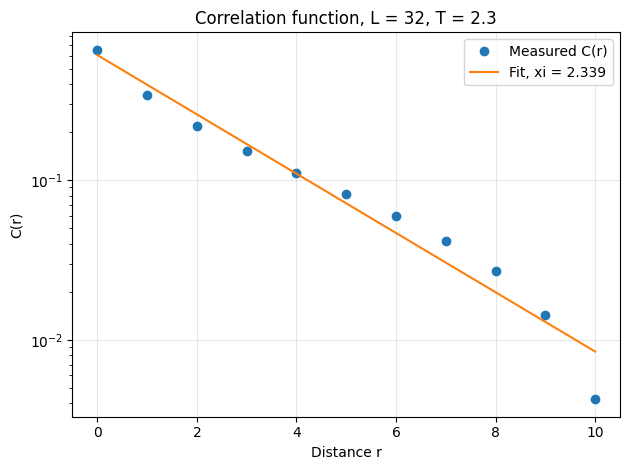

In [ ]:
#  Cell 8: correlation length helpers 

def estimate_correlation_function(
    spins_samples: List[np.ndarray], max_distance: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Estimate the spin correlation function C(r) from saved configurations.

    Args:
        spins_samples (List[np.ndarray]): List of 2D spin configurations.
        max_distance (int): Maximum spin separation r to consider.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Distances r and correlation values C(r).
    """
    l = spins_samples[0].shape[0]
    num_samples = len(spins_samples)

    r_values = np.arange(0, max_distance + 1, dtype=int)
    c_accum = np.zeros_like(r_values, dtype=float)

    for spins in spins_samples:
        m = np.mean(spins)
        for idx, r in enumerate(r_values):
            prod = spins * np.roll(spins, shift=-r, axis=1)
            c_r = np.mean(prod) - m * m
            c_accum[idx] += c_r

    c_r_values = c_accum / num_samples
    return r_values, c_r_values


In [ ]:
#  Cell 9: correlation length run (L = 32, T = 2.3) 

def run_correlation_length() -> None:
    """Estimate the correlation length of the 2D Ising model near T_c.

    The run:
        - L = 32 at T = 2.3.
        - Burn-in then measurement sweeps, sampling configurations.
        - Computes C(r) and fits an exponential decay to extract xi.
        - Prints xi and shows C(r) plot with fit.

    Args:
        None

    Returns:
        None
    """
    rng = make_rng(seed=456)

    lattice_size = 32
    temperature = 2.3
    beta = 1.0 / temperature

    num_burn_in_sweeps = 10000
    num_measure_sweeps = 50000
    sample_interval = 50
    max_distance = 10

    spins = ising2d_initial_state(lattice_size=lattice_size, rng=rng)

    for _ in range(num_burn_in_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)

    samples = []
    for sweep in range(num_measure_sweeps):
        metropolis_sweep_2d(spins, beta=beta, rng=rng)
        if sweep % sample_interval == 0:
            samples.append(spins.copy())

    r_values, c_r_values = estimate_correlation_function(samples, max_distance)

    fit_mask = (r_values >= 1) & (r_values <= max_distance)
    r_fit = r_values[fit_mask].astype(float)
    c_fit = c_r_values[fit_mask]

    positive_mask = c_fit > 0.0
    r_fit = r_fit[positive_mask]
    c_fit = c_fit[positive_mask]

    log_c = np.log(c_fit)
    slope, log_c0 = np.polyfit(r_fit, log_c, 1)
    xi = -1.0 / slope

    print(
        f"Estimated correlation length at T = {temperature:.3f}: "
        f"xi = {xi:.3f} lattice spacings"
    )

    plt.figure()
    plt.semilogy(r_values, c_r_values, "o", label="Measured C(r)")
    c_fit_curve = np.exp(log_c0 + slope * r_values)
    plt.semilogy(r_values, c_fit_curve, "-", label=f"Fit, xi = {xi:.3f}")
    plt.xlabel("Distance r")
    plt.ylabel("C(r)")
    plt.title(f"Correlation function, L = {lattice_size}, T = {temperature}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



run_correlation_length()


In [ ]:
#  Cell 10: parallel tempering and statistics helpers 

@dataclass
class PTConfig:
    """Configuration parameters for a parallel tempering run.

    Attributes:
        lattice_size (int): Linear lattice size L.
        num_replicas (int): Number of temperature replicas.
        temperature_min (float): Minimum temperature in the PT ladder.
        temperature_max (float): Maximum temperature in the PT ladder.
        num_sweeps (int): Total number of sweeps in the PT run.
        burn_in_sweeps (int): Number of sweeps used for burn-in.
        sample_interval (int): Interval in sweeps between recorded samples.
        swap_interval (int): Interval in sweeps between attempted replica swaps.
        random_seed (int): Integer random seed for reproducibility.
    """

    lattice_size: int
    num_replicas: int
    temperature_min: float
    temperature_max: float
    num_sweeps: int
    burn_in_sweeps: int
    sample_interval: int
    swap_interval: int
    random_seed: int


def run_parallel_tempering(config: PTConfig) -> Tuple[np.ndarray, np.ndarray]:
    """Run parallel tempering for the 2D Ising model.

    Args:
        config (PTConfig): Parallel tempering configuration parameters.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Temperatures and energy samples per replica.
    """
    rng = make_rng(config.random_seed)
    l = config.lattice_size
    num_sites = l * l

    temperatures = np.linspace(
        config.temperature_min, config.temperature_max, config.num_replicas
    )
    betas = 1.0 / temperatures

    spins_list: List[np.ndarray] = []
    energies = np.zeros(config.num_replicas, dtype=float)

    for _ in range(config.num_replicas):
        spins = ising2d_initial_state(lattice_size=l, rng=rng)
        spins_list.append(spins)

    for i in range(config.num_replicas):
        energies[i] = ising2d_energy(spins_list[i])

    num_sweeps_total = config.num_sweeps
    burn_in = config.burn_in_sweeps
    sample_interval = config.sample_interval
    swap_interval = config.swap_interval

    energy_samples_list: List[np.ndarray] = []

    swap_attempts = 0
    swap_accepts = 0

    for sweep in range(num_sweeps_total):
        for r_idx in range(config.num_replicas):
            beta = betas[r_idx]
            metropolis_sweep_2d(spins_list[r_idx], beta=beta, rng=rng)
            energies[r_idx] = ising2d_energy(spins_list[r_idx])

        if sweep % swap_interval == 0:
            for r_idx in range(config.num_replicas - 1):
                beta_i = betas[r_idx]
                beta_j = betas[r_idx + 1]
                e_i = energies[r_idx]
                e_j = energies[r_idx + 1]
                delta = (beta_i - beta_j) * (e_j - e_i)
                if delta <= 0.0:
                    accept = True
                else:
                    accept = rng.random() < math.exp(-delta)
                swap_attempts += 1
                if accept:
                    swap_accepts += 1
                    spins_list[r_idx], spins_list[r_idx + 1] = (
                        spins_list[r_idx + 1],
                        spins_list[r_idx],
                    )
                    energies[r_idx], energies[r_idx + 1] = (
                        energies[r_idx + 1],
                        energies[r_idx],
                    )

        if sweep >= burn_in and (sweep - burn_in) % sample_interval == 0:
            e_per_spin = energies / num_sites
            energy_samples_list.append(e_per_spin.copy())

    energies_samples = np.array(energy_samples_list)
    num_samples = energies_samples.shape[0]

    acceptance_rate = swap_accepts / max(1, swap_attempts)
    print(
        "Parallel tempering summary: "
        f"replicas = {config.num_replicas}, sweeps = {config.num_sweeps}, "
        f"samples = {num_samples}"
    )
    print(
        f"Total swap attempts = {swap_attempts}, accepted = {swap_accepts}, "
        f"acceptance rate = {acceptance_rate:.3f}"
    )

    plt.figure()
    for r_idx in range(config.num_replicas):
        plt.plot(
            np.arange(num_samples),
            energies_samples[:, r_idx],
            label=f"Replica {r_idx}, T={temperatures[r_idx]:.3f}",
            alpha=0.6,
        )
    plt.xlabel("Sample index")
    plt.ylabel("Energy per spin")
    plt.title(f"Parallel tempering energy traces, L = {config.lattice_size}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return temperatures, energies_samples


def autocorrelation(x: np.ndarray, max_lag: int) -> np.ndarray:
    """Estimate the autocorrelation function up to a maximum lag.

    Args:
        x (np.ndarray): One dimensional array of observations.
        max_lag (int): Maximum lag to compute.

    Returns:
        np.ndarray: Autocorrelation values for lags 0 to max_lag.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    x_mean = np.mean(x)
    x_centered = x - x_mean
    var = np.dot(x_centered, x_centered) / n
    acf = np.empty(max_lag + 1, dtype=float)
    acf[0] = 1.0
    for lag in range(1, max_lag + 1):
        if lag >= n:
            acf[lag] = 0.0
        else:
            acf[lag] = (
                np.dot(x_centered[:-lag], x_centered[lag:]) / (n - lag) / var
            )
    return acf


def integrated_autocorrelation_time(x: np.ndarray, max_lag: int) -> float:
    """Estimate the integrated autocorrelation time of a time series.

    Args:
        x (np.ndarray): One dimensional array of observations.
        max_lag (int): Maximum lag to include in the sum.

    Returns:
        float: Integrated autocorrelation time in units of samples.
    """
    acf = autocorrelation(x, max_lag=max_lag)
    tau_int = 0.5
    for lag in range(1, max_lag + 1):
        if acf[lag] <= 0.0:
            break
        tau_int += acf[lag]
    return tau_int


Parallel tempering summary: replicas = 8, sweeps = 120000, samples = 2000
Total swap attempts = 84000, accepted = 23579, acceptance rate = 0.281


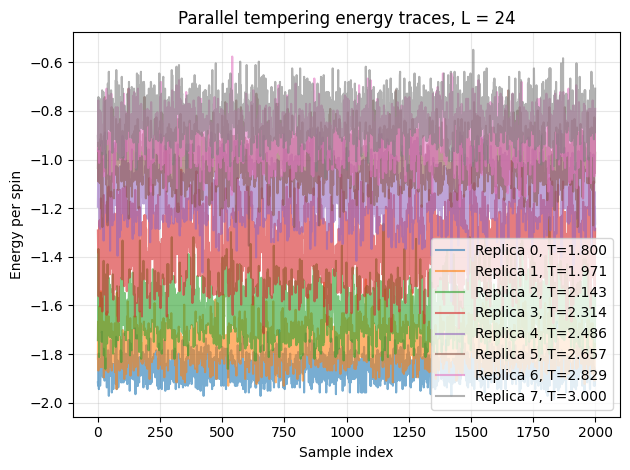

In [ ]:
#  Cell 11: run parallel tempering only (L = 24, T in [1.8, 3.0]) 

def run_parallel_tempering_mode() -> Tuple[np.ndarray, np.ndarray]:
    """Run the parallel tempering extension with fixed parameters.

    Uses:
        - L = 24
        - num_replicas = 8
        - T in [1.8, 3.0]
        - sweeps = 120000
        - burn-in = 20000
        - sample_interval = 50
        - swap_interval = 10
        - seed = 123

    Args:
        None

    Returns:
        Tuple[np.ndarray, np.ndarray]: Temperatures and energy samples per replica.
    """
    config = PTConfig(
        lattice_size=24,
        num_replicas=8,
        temperature_min=1.8,
        temperature_max=3.0,
        num_sweeps=120000,
        burn_in_sweeps=20000,
        sample_interval=50,
        swap_interval=10,
        random_seed=123,
    )
    return run_parallel_tempering(config)



#temps_pt, energies_pt = run_parallel_tempering_mode()


Running PT vs Metropolis comparison for L = 16
Parallel tempering summary: replicas = 8, sweeps = 80000, samples = 1200
Total swap attempts = 56000, accepted = 25739, acceptance rate = 0.460


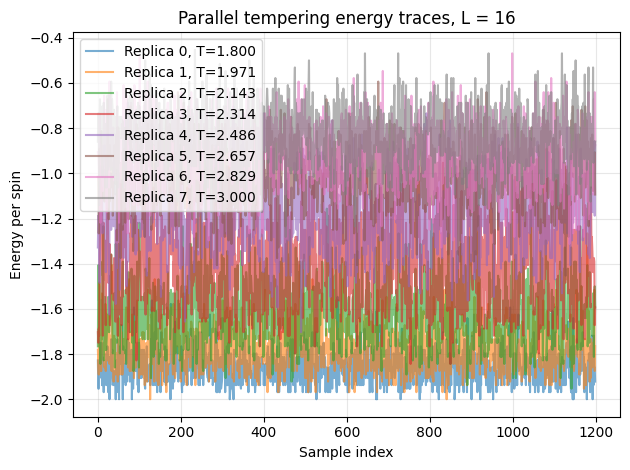

Running PT vs Metropolis comparison for L = 24
Parallel tempering summary: replicas = 8, sweeps = 80000, samples = 1200
Total swap attempts = 56000, accepted = 15751, acceptance rate = 0.281


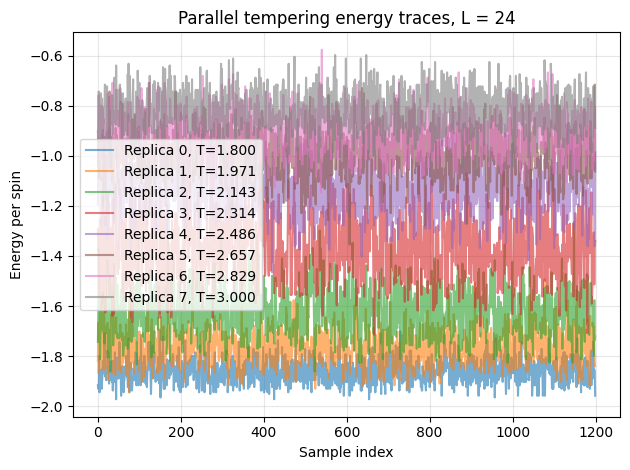

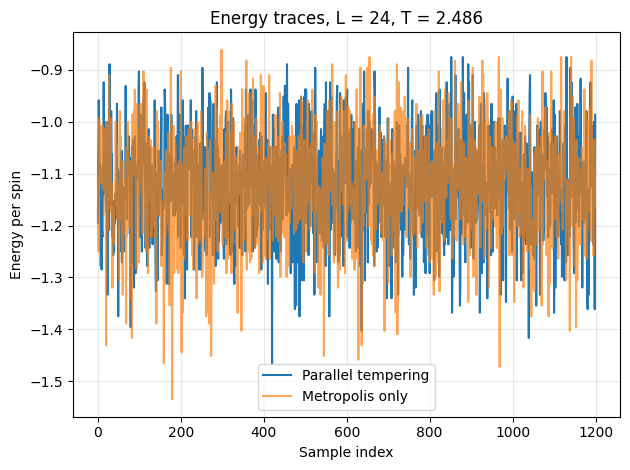

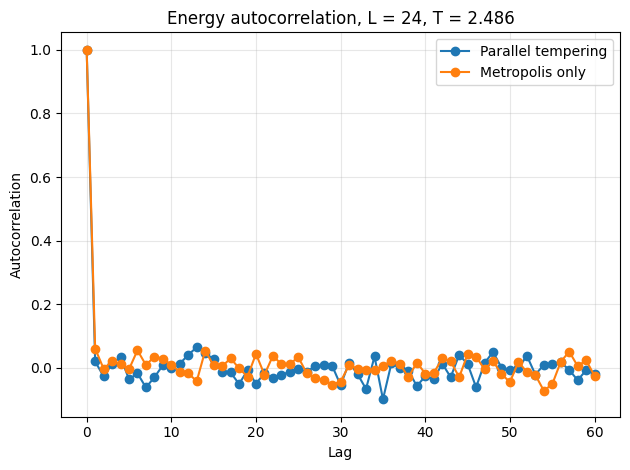


Summary of PT vs Metropolis (energy):
L      T        tau_PT   N_eff_PT   SE_PT     tau_Met  N_eff_Met  SE_Met    var_mean_ratio
16    2.486     0.57     1059.2  4.985e-03     0.63      950.1  5.333e-03      1.14
24    2.486     0.52     1153.9  2.943e-03     0.56     1070.6  3.154e-03      1.15


In [ ]:
#  Cell 12: PT vs Metropolis comparison for multiple lattice sizes 

def compute_series_stats(x: np.ndarray) -> Tuple[float, float, float, float, float]:
    """Compute basic Monte Carlo statistics for an observable time series.

    Args:
        x (np.ndarray): Time series of observable values.

    Returns:
        Tuple[float, float, float, float, float]:
            Mean, variance, integrated autocorrelation time, effective
            sample size and standard error.
    """
    x = np.asarray(x, dtype=float)
    mean_x = float(np.mean(x))
    var_x = float(np.var(x, ddof=1))
    max_lag = max(1, len(x) // 10)
    tau_int = integrated_autocorrelation_time(x, max_lag=max_lag)
    n_eff = len(x) / (2.0 * tau_int)
    se = math.sqrt(var_x / max(n_eff, 1.0))
    return mean_x, var_x, tau_int, n_eff, se


def run_pt_vs_metropolis_comparison_multi(
    lattice_sizes: List[int],
    num_sweeps: int = 60000,
    burn_in_sweeps: int = 20000,
    sample_interval: int = 50,
) -> None:
    """Compare parallel tempering and Metropolis at T close to Tc for several L.

    For each lattice size:
        - Run parallel tempering with fixed ladder.
        - Extract the replica nearest T = 2.486.
        - Run single-chain Metropolis at the same temperature.
        - Compute tau_int, N_eff and SE and print a compact table.

    Args:
        lattice_sizes (List[int]): List of lattice sizes L to study.
        num_sweeps (int): Total sweeps for each algorithm (after burn-in).
        burn_in_sweeps (int): Burn-in sweeps.
        sample_interval (int): Sample interval in sweeps.

    Returns:
        None
    """
    t_min = 1.8
    t_max = 3.0
    num_replicas = 8
    t_target = 2.486

    results_rows = []

    for l in lattice_sizes:
        print(f"Running PT vs Metropolis comparison for L = {l}")
        pt_config = PTConfig(
            lattice_size=l,
            num_replicas=num_replicas,
            temperature_min=t_min,
            temperature_max=t_max,
            num_sweeps=num_sweeps + burn_in_sweeps,
            burn_in_sweeps=burn_in_sweeps,
            sample_interval=sample_interval,
            swap_interval=10,
            random_seed=123,
        )

        temperatures, energies_samples = run_parallel_tempering(pt_config)
        num_samples, _ = energies_samples.shape

        # Pick replica closest to t_target
        idx_target = int(np.argmin(np.abs(temperatures - t_target)))
        t_pt = float(temperatures[idx_target])
        e_pt_series = energies_samples[:, idx_target]

        mean_pt, var_pt, tau_pt, n_eff_pt, se_pt = compute_series_stats(e_pt_series)

        # Metropolis at same T
        rng = make_rng(seed=999 + l)
        beta = 1.0 / t_pt
        spins = ising2d_initial_state(lattice_size=l, rng=rng)

        for _ in range(burn_in_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng)

        e_met_samples = []
        for sweep in range(num_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng)
            if sweep % sample_interval == 0:
                e, _ = measure_observables_2d(spins, beta)
                e_met_samples.append(e)

        e_met_series = np.array(e_met_samples, dtype=float)
        mean_met, var_met, tau_met, n_eff_met, se_met = compute_series_stats(
            e_met_series
        )

        var_mean_pt = var_pt / max(n_eff_pt, 1.0)
        var_mean_met = var_met / max(n_eff_met, 1.0)
        speedup_variance = var_mean_met / var_mean_pt

        results_rows.append(
            (
                l,
                t_pt,
                tau_pt,
                n_eff_pt,
                se_pt,
                tau_met,
                n_eff_met,
                se_met,
                speedup_variance,
            )
        )

        # For one size (say the largest), produce the comparison plots
        if l == max(lattice_sizes):
            plt.figure()
            plt.plot(e_pt_series, label="Parallel tempering")
            plt.plot(e_met_series, label="Metropolis only", alpha=0.7)
            plt.xlabel("Sample index")
            plt.ylabel("Energy per spin")
            plt.title(f"Energy traces, L = {l}, T = {t_pt:.3f}")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            max_lag_plot = max(50, len(e_pt_series) // 20)
            acf_pt = autocorrelation(e_pt_series, max_lag=max_lag_plot)
            acf_met = autocorrelation(e_met_series, max_lag=max_lag_plot)
            lags = np.arange(max_lag_plot + 1)

            plt.figure()
            plt.plot(lags, acf_pt, "o-", label="Parallel tempering")
            plt.plot(lags, acf_met, "o-", label="Metropolis only")
            plt.xlabel("Lag")
            plt.ylabel("Autocorrelation")
            plt.title(f"Energy autocorrelation, L = {l}, T = {t_pt:.3f}")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

    # Print compact comparison table
    print("\nSummary of PT vs Metropolis (energy):")
    header = (
        "L      T        tau_PT   N_eff_PT   SE_PT     "
        "tau_Met  N_eff_Met  SE_Met    var_mean_ratio"
    )
    print(header)
    for row in results_rows:
        (
            l,
            t_pt,
            tau_pt,
            n_eff_pt,
            se_pt,
            tau_met,
            n_eff_met,
            se_met,
            speedup_variance,
        ) = row
        print(
            f"{l:2d}  {t_pt:7.3f}  {tau_pt:7.2f}  {n_eff_pt:9.1f}  {se_pt:7.3e}  "
            f"{tau_met:7.2f}  {n_eff_met:9.1f}  {se_met:7.3e}  {speedup_variance:8.2f}"
        )


#  call: compare L = 16 and L = 24
#run_pt_vs_metropolis_comparison_multi([16, 24])


Monte Carlo estimation of pi
---------------------------
Number of runs            : 1000
Samples per run           : 10000
Sample mean of pi_hat     : 3.141916
Sample std of pi_hat      : 0.016514
Std error of mean(pi_hat) : 0.000522
True pi                   : 3.141593
Bias (mean - pi)          : 0.000323
Predicted std(pi_hat) (CLT): 0.016422


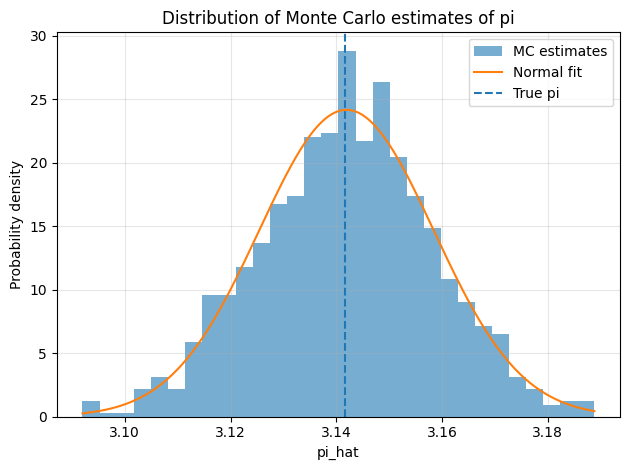

T = 0.010  <E>/N = -2.0000 +/- 0.0000  <|m|> = 0.0000 +/- 0.0000  <|m_s|> = 1.0000 +/- 0.0000
T = 0.220  <E>/N = -2.0000 +/- 0.0000  <|m|> = 0.0000 +/- 0.0000  <|m_s|> = 1.0000 +/- 0.0000
T = 0.430  <E>/N = -2.0000 +/- 0.0000  <|m|> = 0.0000 +/- 0.0000  <|m_s|> = 1.0000 +/- 0.0000
T = 0.640  <E>/N = -2.0000 +/- 0.0000  <|m|> = 0.0000 +/- 0.0000  <|m_s|> = 1.0000 +/- 0.0000
T = 0.850  <E>/N = -1.9993 +/- 0.0001  <|m|> = 0.0002 +/- 0.0000  <|m_s|> = 0.9998 +/- 0.0000
T = 1.060  <E>/N = -1.9953 +/- 0.0007  <|m|> = 0.0010 +/- 0.0001  <|m_s|> = 0.9988 +/- 0.0002
T = 1.270  <E>/N = -1.9826 +/- 0.0011  <|m|> = 0.0030 +/- 0.0003  <|m_s|> = 0.9954 +/- 0.0003
T = 1.480  <E>/N = -1.9550 +/- 0.0007  <|m|> = 0.0060 +/- 0.0002  <|m_s|> = 0.9876 +/- 0.0002
T = 1.690  <E>/N = -1.9021 +/- 0.0020  <|m|> = 0.0090 +/- 0.0003  <|m_s|> = 0.9716 +/- 0.0008
T = 1.900  <E>/N = -1.8091 +/- 0.0003  <|m|> = 0.0121 +/- 0.0002  <|m_s|> = 0.9383 +/- 0.0010
T = 2.110  <E>/N = -1.6567 +/- 0.0034  <|m|> = 0.0161 +/- 0.

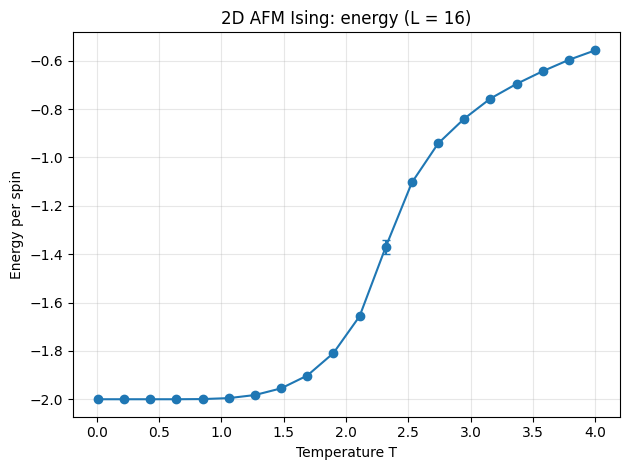

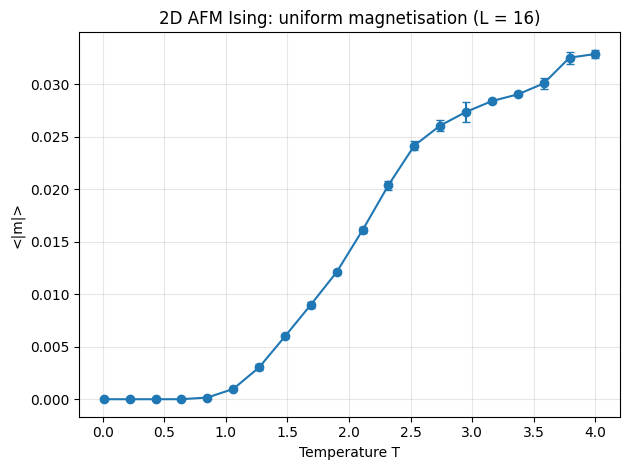

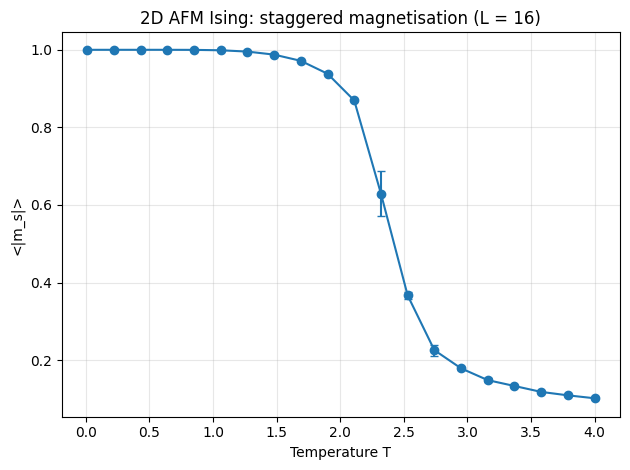

In [ ]:
#Cell 13 :tasks 1 & 2 & 5
# # Monte Carlo estimate of pi


def estimate_pi(num_points: int, rng: np.random.Generator) -> float:
    """Single Monte Carlo estimate of pi using the unit quarter-circle method.

    Draw (x, y) uniformly in [0, 1] x [0, 1] and count the fraction inside
    the quarter-circle x^2 + y^2 <= 1. Then pi approx 4 * fraction.
    """
    x = rng.random(num_points)
    y = rng.random(num_points)
    inside = (x * x + y * y) <= 1.0
    return 4.0 * float(np.mean(inside))


def run_pi_experiments(
    num_points_per_run: int = 10000,
    num_runs: int = 1000,
    seed: int = 2025,
) -> None:
    """Task 1 and 2: generate many Monte Carlo estimates of pi and analyse them.

    - Computes pi_hat for each run.
    - Prints mean, standard deviation, standard error and bias.
    - Compares empirical std with CLT prediction.
    - Plots histogram of estimates with a normal fit overlay.
    """
    rng = make_rng(seed)
    estimates = np.empty(num_runs, dtype=float)

    for k in range(num_runs):
        estimates[k] = estimate_pi(num_points_per_run, rng)

    mean_est = float(np.mean(estimates))
    std_est = float(np.std(estimates, ddof=1))
    se_mean = std_est / math.sqrt(num_runs)

    print("Monte Carlo estimation of pi")
    print("---------------------------")
    print(f"Number of runs            : {num_runs}")
    print(f"Samples per run           : {num_points_per_run}")
    print(f"Sample mean of pi_hat     : {mean_est:.6f}")
    print(f"Sample std of pi_hat      : {std_est:.6f}")
    print(f"Std error of mean(pi_hat) : {se_mean:.6f}")
    print(f"True pi                   : {math.pi:.6f}")
    print(f"Bias (mean - pi)          : {mean_est - math.pi:.6f}")

    # CLT prediction for the standard deviation of a single-run estimator.
    # Indicator variable I = 1 if point is inside quarter-circle, 0 otherwise.
    # P(I=1) = pi/4. For N points, var(pi_hat) = 16 var(I)/N.
    p = math.pi / 4.0
    var_indicator = p * (1.0 - p)
    std_theory_single = 4.0 * math.sqrt(var_indicator / num_points_per_run)
    print(f"Predicted std(pi_hat) (CLT): {std_theory_single:.6f}")

    # Histogram of estimates with a Gaussian fit.
    plt.figure()
    plt.hist(
        estimates,
        bins=30,
        density=True,
        alpha=0.6,
        label="MC estimates",
    )

    x_vals = np.linspace(estimates.min(), estimates.max(), 200)
    normal_pdf = (
        1.0 / (std_est * math.sqrt(2.0 * math.pi))
        * np.exp(-0.5 * ((x_vals - mean_est) / std_est) ** 2)
    )
    plt.plot(x_vals, normal_pdf, "-", label="Normal fit")
    plt.axvline(math.pi, linestyle="--", label="True pi")

    plt.xlabel("pi_hat")
    plt.ylabel("Probability density")
    plt.title("Distribution of Monte Carlo estimates of pi")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


run_pi_experiments()


#Task 5  2D antiferromagnetic Ising model


def measure_observables_2d_afm(
    spins: np.ndarray,
    coupling: float = -1.0,
) -> Tuple[float, float, float]:
    """Measure energy per spin, uniform magnetisation and staggered magnetisation.

    Args:
        spins: 2D array of spins +-1.
        coupling: J in the Hamiltonian H = -J sum s_i s_j. For the AFM, use J < 0.

    Returns:
        (energy_per_spin, m_uniform, m_staggered)
    """
    energy = ising2d_energy(spins, coupling=coupling)
    num_sites = spins.size
    m_uniform = float(np.sum(spins)) / num_sites

    # Staggered magnetisation: multiply one sublattice by -1.
    L = spins.shape[0]
    i_idx, j_idx = np.indices((L, L))
    stagger_factor = 1 - 2 * ((i_idx + j_idx) % 2)  # +1 on even, -1 on odd sublattice
    m_stagg = float(np.sum(spins * stagger_factor)) / num_sites

    return energy / num_sites, m_uniform, m_stagg


def run_ising2d_antiferromagnetic_sweep(
    lattice_size: int = 16,
    t_min: float = 0.01,
    t_max: float = 4.0,
    num_temps: int = 20,
    num_burn_in_sweeps: int = 5000,
    num_measure_sweeps: int = 20000,
    sample_interval: int = 10,
    seed: int = 4242,
) -> None:
    """Task 5: analyse the 2D antiferromagnetic Ising model.

    Uses the existing Metropolis sweep with coupling = -1.0 to realise
    antiferromagnetic interactions on the square lattice.

    Produces:
        - Energy per spin vs T.
        - |m| vs T (uniform magnetisation).
        - |m_s| vs T (staggered magnetisation, AFM order parameter).
    """
    rng = make_rng(seed)

    temperatures = np.linspace(t_min, t_max, num_temps)
    beta_values = 1.0 / temperatures

    spins = ising2d_initial_state(lattice_size=lattice_size, rng=rng)

    e_means, e_errs = [], []
    m_abs_means, m_abs_errs = [], []
    ms_abs_means, ms_abs_errs = [], []

    for beta, T in zip(beta_values, temperatures):
        # Burn-in
        for _ in range(num_burn_in_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng, coupling=-1.0)

        e_samples = []
        m_samples = []
        ms_samples = []

        for sweep in range(num_measure_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng, coupling=-1.0)
            if sweep % sample_interval == 0:
                e, m, ms = measure_observables_2d_afm(spins)
                e_samples.append(e)
                m_samples.append(m)
                ms_samples.append(ms)

        e_arr = np.asarray(e_samples, dtype=float)
        m_arr = np.asarray(m_samples, dtype=float)
        ms_arr = np.asarray(ms_samples, dtype=float)

        e_mean, e_se = blocking_error(e_arr)
        m_abs_mean, m_abs_se = blocking_error(np.abs(m_arr))
        ms_abs_mean, ms_abs_se = blocking_error(np.abs(ms_arr))

        e_means.append(e_mean)
        e_errs.append(e_se)
        m_abs_means.append(m_abs_mean)
        m_abs_errs.append(m_abs_se)
        ms_abs_means.append(ms_abs_mean)
        ms_abs_errs.append(ms_abs_se)

        print(
            f"T = {T:5.3f}  "
            f"<E>/N = {e_mean: .4f} +/- {e_se:.4f}  "
            f"<|m|> = {m_abs_mean:.4f} +/- {m_abs_se:.4f}  "
            f"<|m_s|> = {ms_abs_mean:.4f} +/- {ms_abs_se:.4f}"
        )

    temperatures = np.asarray(temperatures)
    e_means = np.asarray(e_means)
    e_errs = np.asarray(e_errs)
    m_abs_means = np.asarray(m_abs_means)
    m_abs_errs = np.asarray(m_abs_errs)
    ms_abs_means = np.asarray(ms_abs_means)
    ms_abs_errs = np.asarray(ms_abs_errs)

    # Energy vs T
    plt.figure()
    plt.errorbar(
        temperatures,
        e_means,
        yerr=e_errs,
        fmt="o-",
        capsize=3,
    )
    plt.xlabel("Temperature T")
    plt.ylabel("Energy per spin")
    plt.title(f"2D AFM Ising: energy (L = {lattice_size})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Uniform |m| vs T
    plt.figure()
    plt.errorbar(
        temperatures,
        m_abs_means,
        yerr=m_abs_errs,
        fmt="o-",
        capsize=3,
    )
    plt.xlabel("Temperature T")
    plt.ylabel("<|m|>")
    plt.title(f"2D AFM Ising: uniform magnetisation (L = {lattice_size})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Staggered |m_s| vs T - proper AFM order parameter
    plt.figure()
    plt.errorbar(
        temperatures,
        ms_abs_means,
        yerr=ms_abs_errs,
        fmt="o-",
        capsize=3,
    )
    plt.xlabel("Temperature T")
    plt.ylabel("<|m_s|>")
    plt.title(f"2D AFM Ising: staggered magnetisation (L = {lattice_size})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


run_ising2d_antiferromagnetic_sweep()



=== AFM scan for L = 16 ===
L = 16, T = 1.800  <E>/N = -1.8603 +/- 0.0014  <|m_s|> = 0.9574 +/- 0.0011  C_v = 0.4601 +/- 0.5663  chi_s = 0.119 +/- 0.400
L = 16, T = 1.852  <E>/N = -1.8371 +/- 0.0034  <|m_s|> = 0.9494 +/- 0.0013  C_v = 0.4747 +/- 1.2728  chi_s = 0.135 +/- 0.475
L = 16, T = 1.904  <E>/N = -1.8093 +/- 0.0068  <|m_s|> = 0.9388 +/- 0.0026  C_v = 0.5476 +/- 2.4184  chi_s = 0.177 +/- 0.900
L = 16, T = 1.957  <E>/N = -1.7760 +/- 0.0063  <|m_s|> = 0.9237 +/- 0.0054  C_v = 0.6984 +/- 2.1077  chi_s = 0.334 +/- 1.771
L = 16, T = 2.009  <E>/N = -1.7392 +/- 0.0117  <|m_s|> = 0.9098 +/- 0.0060  C_v = 0.7235 +/- 3.6195  chi_s = 0.337 +/- 1.918
L = 16, T = 2.061  <E>/N = -1.6978 +/- 0.0108  <|m_s|> = 0.8900 +/- 0.0055  C_v = 0.8137 +/- 3.1241  chi_s = 0.491 +/- 1.703
L = 16, T = 2.113  <E>/N = -1.6390 +/- 0.0005  <|m_s|> = 0.8518 +/- 0.0034  C_v = 1.0290 +/- 0.1970  chi_s = 1.430 +/- 0.693
L = 16, T = 2.165  <E>/N = -1.5898 +/- 0.0054  <|m_s|> = 0.8243 +/- 0.0059  C_v = 1.1389 +/- 1.3

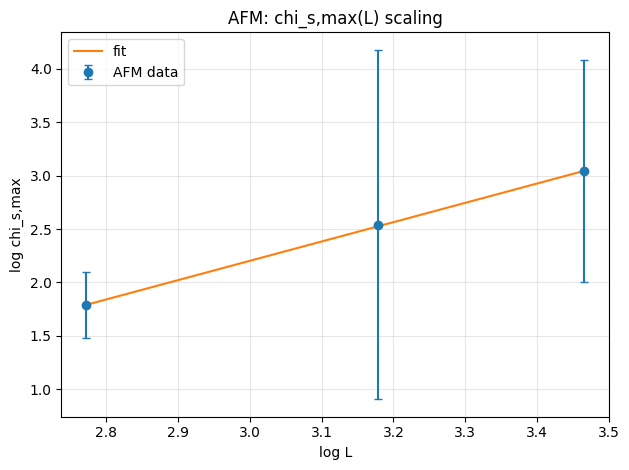

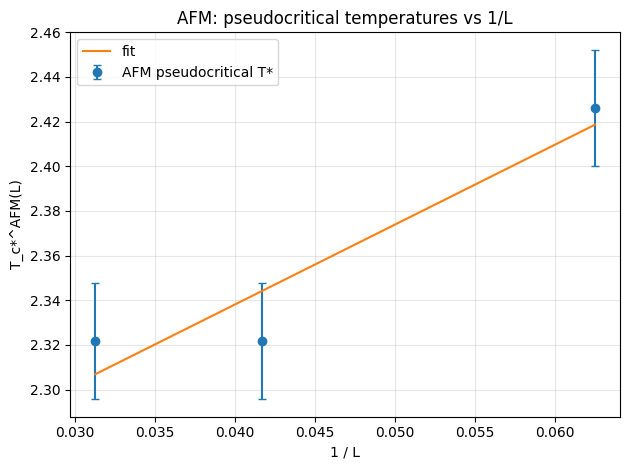

In [ ]:
# Cell 14 : AFM critical analysis: multi-L FSS on staggered susceptibility 

def run_afm_single_L_collect(
    lattice_size: int = 16,
    t_min: float = 1.8,
    t_max: float = 3.0,
    num_temps: int = 24,
    num_burn_in_sweeps: int = 4000,
    num_measure_sweeps: int = 12000,
    sample_interval: int = 10,
    seed: int = 777,
):
    """Run an antiferromagnetic 2D Ising scan for a single lattice size.

    For a given lattice size L, this function performs a temperature sweep for the
    AFM Ising model (J = -1) and measures:
        - energy per spin,
        - staggered order parameter |m_s|,
        - specific heat C_v(T),
        - staggered susceptibility chi_s(T).

    

    Args:
        lattice_size (int): Linear lattice size L of the square lattice.
        t_min (float): Minimum temperature in the sweep.
        t_max (float): Maximum temperature in the sweep.
        num_temps (int): Number of temperature points between t_min and t_max.
        num_burn_in_sweeps (int): Number of Metropolis sweeps for burn-in at each T.
        num_measure_sweeps (int): Number of Metropolis sweeps used for measurement.
        sample_interval (int): Number of sweeps between recorded samples.
        seed (int): Integer random seed for the RNG.

    Returns:
        dict: Dictionary with the following entries (all np.ndarray except T):
            - "T": array of temperatures.
            - "e_mean": mean energy per spin at each T.
            - "e_err": standard error on the energy per spin.
            - "ms_abs": mean absolute staggered magnetisation |m_s| at each T.
            - "ms_abs_err": standard error on |m_s|.
            - "Cv": specific heat C_v(T) at each T.
            - "Cv_err": standard error on C_v(T).
            - "chi_s": staggered susceptibility chi_s(T) at each T.
            - "chi_s_err": standard error on chi_s(T).
    """
    rng = make_rng(seed)
    L = lattice_size
    N = L * L

    temperatures = np.linspace(t_min, t_max, num_temps)
    beta_values = 1.0 / temperatures

    spins = ising2d_initial_state(lattice_size=L, rng=rng)

    e_means, e_errs = [], []
    ms_abs_means, ms_abs_errs = [], []
    cv_means, cv_errs = [], []
    chi_s_means, chi_s_errs = [], []

    for beta, T in zip(beta_values, temperatures):
        # Burn-in with AFM coupling
        for _ in range(num_burn_in_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng, coupling=-1.0)

        e_samples = []
        m_samples = []
        ms_samples = []

        for sweep in range(num_measure_sweeps):
            metropolis_sweep_2d(spins, beta=beta, rng=rng, coupling=-1.0)
            if sweep % sample_interval == 0:
                e, m, ms = measure_observables_2d_afm(spins, coupling=-1.0)
                e_samples.append(e)
                m_samples.append(m)
                ms_samples.append(ms)

        e_arr = np.asarray(e_samples, dtype=float)
        m_arr = np.asarray(m_samples, dtype=float)
        ms_arr = np.asarray(ms_samples, dtype=float)

        # Means and errors via blocking
        e_mean, e_se = blocking_error(e_arr)
        ms_abs_arr = np.abs(ms_arr)
        ms_abs_mean, ms_abs_se = blocking_error(ms_abs_arr)

        # Specific heat: C_v = N/T^2 ( <e^2> - <e>^2 )
        e_sq_arr = e_arr ** 2
        e_sq_mean, e_sq_se = blocking_error(e_sq_arr)
        Cv = N * (e_sq_mean - e_mean ** 2) / (T ** 2)
        Cv_err = (N / (T ** 2)) * math.sqrt(
            e_sq_se ** 2 + (2.0 * e_mean * e_se) ** 2
        )

        # Staggered susceptibility: chi_s = N/T ( <m_s^2> - <|m_s|>^2 )
        ms_sq_arr = ms_arr ** 2
        ms_sq_mean, ms_sq_se = blocking_error(ms_sq_arr)
        chi_s = (N / T) * (ms_sq_mean - ms_abs_mean ** 2)
        chi_s_err = (N / T) * math.sqrt(
            ms_sq_se ** 2 + (2.0 * ms_abs_mean * ms_abs_se) ** 2
        )

        e_means.append(e_mean)
        e_errs.append(e_se)
        ms_abs_means.append(ms_abs_mean)
        ms_abs_errs.append(ms_abs_se)
        cv_means.append(Cv)
        cv_errs.append(Cv_err)
        chi_s_means.append(chi_s)
        chi_s_errs.append(chi_s_err)

        print(
            f"L = {L:2d}, T = {T:5.3f}  "
            f"<E>/N = {e_mean: .4f} +/- {e_se:.4f}  "
            f"<|m_s|> = {ms_abs_mean:.4f} +/- {ms_abs_se:.4f}  "
            f"C_v = {Cv:.4f} +/- {Cv_err:.4f}  "
            f"chi_s = {chi_s:.3f} +/- {chi_s_err:.3f}"
        )

    return {
        "T": temperatures,
        "e_mean": np.asarray(e_means),
        "e_err": np.asarray(e_errs),
        "ms_abs": np.asarray(ms_abs_means),
        "ms_abs_err": np.asarray(ms_abs_errs),
        "Cv": np.asarray(cv_means),
        "Cv_err": np.asarray(cv_errs),
        "chi_s": np.asarray(chi_s_means),
        "chi_s_err": np.asarray(chi_s_errs),
    }


def analyse_afm_finite_size_scaling(results_by_L):
    """Perform finite-size scaling for the AFM model using chi_s peaks.

    This routine takes AFM data for several lattice sizes and performs a simple
    finite-size scaling analysis based on the staggered susceptibility peaks:
        - Extracts chi_s,max(L) and the corresponding pseudocritical
          temperature T_c*^AFM(L).
        - Fits chi_s,max(L) ~ L^{gamma/nu} in log-log space to obtain gamma/nu.
        - Fits T_c*^AFM(L) = Tc + a / L (assuming nu = 1) to estimate Tc.

    Args:
        results_by_L (dict): Dictionary mapping each lattice size L (int) to the
            dictionary returned by run_afm_single_L_collect. Each entry is
            expected to contain at least:
                - "T": temperature grid,
                - "chi_s": staggered susceptibility values,
                - "chi_s_err": errors on chi_s.

    Returns:
        dict: Dictionary with AFM FSS summary:
            - "L": array of lattice sizes used.
            - "chi_peaks": chi_s,max(L) for each L.
            - "chi_peaks_err": errors on chi_s,max(L).
            - "T_peaks": pseudocritical temperatures T_c*^AFM(L).
            - "gamma_over_nu": fitted gamma/nu exponent.
            - "gamma_over_nu_err": error on gamma/nu.
            - "Tc_inf": extrapolated infinite-volume Tc^AFM.
            - "Tc_inf_err": error on Tc^AFM.
    """
    L_values = sorted(results_by_L.keys())
    L_arr = np.array(L_values, dtype=float)

    # Assume same T grid for all L
    T_grid = np.asarray(results_by_L[L_values[0]]["T"])
    dT = float(T_grid[1] - T_grid[0])

    chi_peaks = []
    chi_peaks_err = []
    T_peaks = []

    print("\nAFM staggered susceptibility peaks:")
    print("-----------------------------------")
    for L in L_values:
        chi_s = np.asarray(results_by_L[L]["chi_s"])
        chi_s_err = np.asarray(results_by_L[L]["chi_s_err"])

        idx = int(np.argmax(chi_s))
        chi_max = float(chi_s[idx])
        chi_max_err = float(chi_s_err[idx])
        T_star = float(T_grid[idx])

        chi_peaks.append(chi_max)
        chi_peaks_err.append(chi_max_err)
        T_peaks.append(T_star)

        print(
            f"L = {L:2d}: T_c*^AFM = {T_star:6.3f},  "
            f"chi_s,max = {chi_max:8.3f} +/- {chi_max_err:8.3f}"
        )

    chi_peaks = np.array(chi_peaks)
    chi_peaks_err = np.array(chi_peaks_err)
    T_peaks = np.array(T_peaks)

    # gamma/nu from chi_s,max(L) ~ L^{gamma/nu}
    logL = np.log(L_arr)
    log_chi = np.log(chi_peaks)
    sigma_log_chi = chi_peaks_err / chi_peaks

    a_chi, b_chi, sigma_a_chi, sigma_b_chi, chi2_g, dof_g = linear_fit_with_errors(
        logL, log_chi, sigma_log_chi
    )
    gamma_over_nu = b_chi
    gamma_over_nu_err = sigma_b_chi

    print("\nAFM finite-size scaling from chi_s,max(L):")
    print("------------------------------------------")
    print(
        f"gamma/nu (AFM) = {gamma_over_nu:.3f} +/- {gamma_over_nu_err:.3f},  "
        f"chi2/dof = {chi2_g / max(dof_g, 1):.2f}"
    )

    # Tc from T_c*(L) = Tc + a / L  (nu = 1)
    x = 1.0 / L_arr
    sigma_T = np.full_like(T_peaks, 0.5 * dT)
    a_tc, b_tc, sigma_a_tc, sigma_b_tc, chi2_T, dof_T = linear_fit_with_errors(
        x, T_peaks, sigma_T
    )
    Tc_inf = a_tc
    Tc_inf_err = sigma_a_tc

    print(
        f"Tc^AFM(infinity) from chi_s peaks = {Tc_inf:.3f} +/- {Tc_inf_err:.3f},  "
        f"chi2/dof = {chi2_T / max(dof_T, 1):.2f}"
    )

    # Plot chi_s,max(L) scaling
    plt.figure()
    plt.errorbar(
        logL, log_chi, yerr=sigma_log_chi, fmt="o", capsize=3, label="AFM data"
    )
    xfit = np.linspace(logL.min(), logL.max(), 200)
    yfit = a_chi + gamma_over_nu * xfit
    plt.plot(xfit, yfit, "-", label="fit")
    plt.xlabel("log L")
    plt.ylabel("log chi_s,max")
    plt.title("AFM: chi_s,max(L) scaling")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Plot T_c*^AFM(L) vs 1/L
    plt.figure()
    plt.errorbar(
        x,
        T_peaks,
        yerr=sigma_T,
        fmt="o",
        capsize=3,
        label="AFM pseudocritical T*",
    )
    xfit = np.linspace(x.min(), x.max(), 200)
    yfit = Tc_inf + b_tc * xfit
    plt.plot(xfit, yfit, "-", label="fit")
    plt.xlabel("1 / L")
    plt.ylabel("T_c*^AFM(L)")
    plt.title("AFM: pseudocritical temperatures vs 1/L")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return {
        "L": L_arr,
        "chi_peaks": chi_peaks,
        "chi_peaks_err": chi_peaks_err,
        "T_peaks": T_peaks,
        "gamma_over_nu": gamma_over_nu,
        "gamma_over_nu_err": gamma_over_nu_err,
        "Tc_inf": Tc_inf,
        "Tc_inf_err": Tc_inf_err,
    }


def run_afm_full_critical_analysis(
    lattice_sizes=(16, 24, 32),
    t_min: float = 1.8,
    t_max: float = 3.0,
    num_temps: int = 24,
    num_burn_in_sweeps: int = 4000,
    num_measure_sweeps: int = 12000,
    sample_interval: int = 10,
    base_seed: int = 9001,
):
    """High-level AFM driver: multi-L scans and FSS on chi_s.

    This is a convenience wrapper that:
        1. Runs run_afm_single_L_collect for each lattice size in lattice_sizes.
        2. Passes the collected data to analyse_afm_finite_size_scaling.
        3. Returns both the raw data and the finite-size scaling summary.

    Args:
        lattice_sizes (tuple[int, ...]): Sequence of lattice sizes L to analyse.
        t_min (float): Minimum temperature of the AFM sweep.
        t_max (float): Maximum temperature of the AFM sweep.
        num_temps (int): Number of temperatures between t_min and t_max.
        num_burn_in_sweeps (int): Burn-in sweeps per (L, T).
        num_measure_sweeps (int): Measurement sweeps per (L, T).
        sample_interval (int): Number of sweeps between recorded samples.
        base_seed (int): Base random seed; each L uses base_seed + 100 * index.

    Returns:
        Tuple[dict, dict]:
            - results_by_L: mapping L -> dict returned by run_afm_single_L_collect.
            - fss_summary: dictionary returned by analyse_afm_finite_size_scaling.
    """
    results_by_L = {}
    for i, L in enumerate(lattice_sizes):
        print(f"\n=== AFM scan for L = {L} ===")
        res = run_afm_single_L_collect(
            lattice_size=L,
            t_min=t_min,
            t_max=t_max,
            num_temps=num_temps,
            num_burn_in_sweeps=num_burn_in_sweeps,
            num_measure_sweeps=num_measure_sweeps,
            sample_interval=sample_interval,
            seed=base_seed + 100 * i,
        )
        results_by_L[L] = res

    fss_summary = analyse_afm_finite_size_scaling(results_by_L)
    return results_by_L, fss_summary


#results_afm, fss_afm = run_afm_full_critical_analysis()
